# Radar Test Data and How We Can Use it
## Marci Detwiller
### University of Saskatchewan

#### October 22, 2018

## What kind of data do we collect on site?
## What can we do with this data after its collected?
## How can we improve our radars with this test data?
- Specifically, an example investigating tdiff, a hardware parameter.

Need more pictures!

Ultimately, we want to use the data we collect to improve our 
radar data quality, whether that is increasing amount of data collected,
calibrating so that elevation data is meaningful, etc.

## Data collection

### Data collected depends on instruments available
- Vector network analyzer (VNA)
- Oscilloscope ('scope')
- Multimeters
- Wattmeters

### Also depends on accessories, including specialized probes and tools
- High voltage probe
- Infrared camera
- Heat gun
- Thermistor probe for multimeter

# Some examples of data collected:

- Propagation delay measurements (VNA)
- Standing wave ratio (VNA)
- Sky noise spectrum (VNA)
- Phase output of direct digital synthesis system (scope)
- Transmitter power output (scope)
- Voltages on transmitters, settings (multimeters) 

<img align="left" style="transform:rotate(90deg);" width="1000" height="800" src="./pictures/20180811_170504.jpg">

<img align="left" width="600" height="200" src="./pictures/IMG_20180810_100312193.jpg">

## Data analysis

## Some data is easily interpreted and allows us to immediately diagnose:
- Bad connections
- Faulty components
- Calibrations required

## What else can we do with this data?
- Some issues are less obvious, so additional analysis can give more insight.

# Vector Network Analyzer

<img src="./pictures/network-analyzer.jpg" width="1000" align="center">

# VNA Measurements 

- Propagation delay measurements
    * pm-path: A transmission measurement (S12) through the phasing matrix. 
    * transmitter-path: A transmission measurement (S12) through the transmitter.
- Standing wave ratio
    * feedline-VSWR: A reflection measurement (S11) from the feedline in the building, out to the antenna, and back.
- Sky noise spectrum
    * I won't show any of this today.

In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
pd.options.mode.chained_assignment = None
import json
import sys
import random
sys.path.append('../tdiff_path/')

# import some modules that I created to do some data processing.

import dataset_operations.dataset_operations as do
import retrieve_data.retrieve_data as retrieve

In [2]:
# I have metadata for all the datasets I have available stored in a csv.
# Includes path to files and a mapping of file to channel name. 
site_file_metadata=pd.read_csv('site_file_metadata.csv')

In [3]:
# Let's check out the data we have available!
available_data = site_file_metadata.loc[:,['site','date','data_type', 'interim_data']]# .sort_values(by=['site', 'date'])

print(available_data)

   site      date         data_type  interim_data
0   CLY  20160628     feedline-VSWR          True
1   CLY  20160701     feedline-VSWR         False
2   CLY  20160701  transmitter-path         False
3   CLY  20160701           pm-path         False
4   CLY  20180817     feedline-VSWR          True
5   CLY  20180817     feedline-VSWR         False
6   CLY  20180817  transmitter-path         False
7   CLY  20180817           pm-path          True
8   CLY  20180817           pm-path         False
9   INV  20170811     feedline-VSWR         False
10  INV  20170813  transmitter-path         False
11  INV  20170813           pm-path         False
12  PGR  20171003     feedline-VSWR         False
13  PGR  20170930     feedline-VSWR          True
14  PGR  20170930  transmitter-path         False
15  PGR  20171001           pm-path         False
16  RKN  20160705     feedline-VSWR          True
17  RKN  20160721     feedline-VSWR         False
18  RKN  20160719  transmitter-path         False


In [15]:
# Now we can choose a site, date, and data type that we want to look at, and pass in the index of the data.

%run load_data.py 25

site                                                              SAS
date                                                         20170627
interim_data                                                    False
data_location       /home/shared/Sync/Sites/Saskatoon/SITE-VISITS-...
mapping_filename    /home/shared/Sync/Sites/Saskatoon/SITE-VISITS-...
data_type                                               feedline-VSWR
Name: 25, dtype: object

The data has been successfully loaded.


<Figure size 432x288 with 0 Axes>

# load_data.py makes the following available to us:
* working_dataframe, with all information on all channels from this site, date, and data type
* linear_fit_dict, with information on the phase path for each channel
* cable_loss_dataset_dict, if we chose feedline-VSWR datatype, which is used to calculate a single-direction path from a VSWR measurement.


In [10]:
# Here is a few lines from the working dataframe and the list of all the columns in the dataframe.
print(working_dataframe.head())
print(list(working_dataframe.columns))

      freq    M0vswr  M0phase_deg    M1vswr  M1phase_deg    M2vswr  \
0  8000000  1.547166   -46.829964  1.522314   -44.909077  1.557816   
1  8030000  1.530756   -53.408615  1.503584   -51.740990  1.537859   
2  8060000  1.507012   -61.366905  1.482400   -59.417206  1.520035   
3  8090000  1.489504   -68.323631  1.463284   -66.885696  1.507523   
4  8120000  1.476641   -76.583496  1.442218   -74.957161  1.485732   

   M2phase_deg    M3vswr  M3phase_deg    M4vswr         ...          \
0   -40.470955  1.521117   -41.320480  1.553311         ...           
1   -47.143185  1.507388   -47.518368  1.532350         ...           
2   -55.075138  1.488011   -56.024693  1.527303         ...           
3   -62.106510  1.471579   -63.390137  1.503557         ...           
4   -69.917908  1.447116   -71.223480  1.479598         ...           

   M_all_phase_deg_unwrap  M_all_phase_rad  M_all_phase_deg  M_all_magnitude  \
0              -46.829964        -0.817337       -46.829964         -2.6

In [11]:
# We can also take a look at what's in the linear_fit_dict:
# Let's look at the dictionary that is in the linear_fit_dict['M0'], showing just the head of the DataFrames
# So we can get an overview of what's there.
print(linear_fit_dict.keys())
print(linear_fit_dict[random.choice(list(linear_fit_dict.keys()))].keys())
viewing_dict = {key: (value.head() if type(value) == pd.Series or type(value) == pd.DataFrame else value) for (key, value) in linear_fit_dict['M0'].items()}
print(viewing_dict)

dict_keys(['M0', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'I0', 'I1', 'I2', 'I3', 'M_all_', 'I_all_'])
dict_keys(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'offset_of_best_fit_rads', 'time_delay_ns', 'best_fit_line_rads'])
{'slope': -4.457346669953116e-06, 'intercept': 34.06704482744874, 'rvalue': -0.9997364616201001, 'pvalue': 0.0, 'stderr': 5.12404283551948e-09, 'offset_of_best_fit_rads': 0    0.774391
1    0.793293
2    0.788115
3    0.800417
4    0.789976
Name: phase_rad, dtype: float64, 'time_delay_ns': 709.41, 'best_fit_line_rads':    phase_rad
0  -1.591729
1  -1.725449
2  -1.859169
3  -1.992890
4  -2.126610}


# Time to plot some things!

## Things that I think are useful to plot:
- path phases, to see differences between individual channels and any non-linearities in the propagation delay.
- combined array phases, to see differences between arrays.
- magnitudes, to see if any paths have lower signal amplitude.

# Tdiff

### A parameter with the following description from the SuperDARN 'hdw.dat' file (config file):

### tdiff
    Propagation time from interferometer array antenna to
    phasing matrix input minus propagation time from main array antenna
    through transmitter to phasing matrix input. If the signal from the
    interferometer comes first, then tdiff < 0. Units are in decimal
    microseconds

### If the propagation time can be based on a single value, then the phase change = wt

        tdiff = phase_through_path_at_freq / (freq * 2 * pi) 

### In other words we will have linear phase over the frequency spectrum, with a slope proportional to the tdiff.
   

plotting


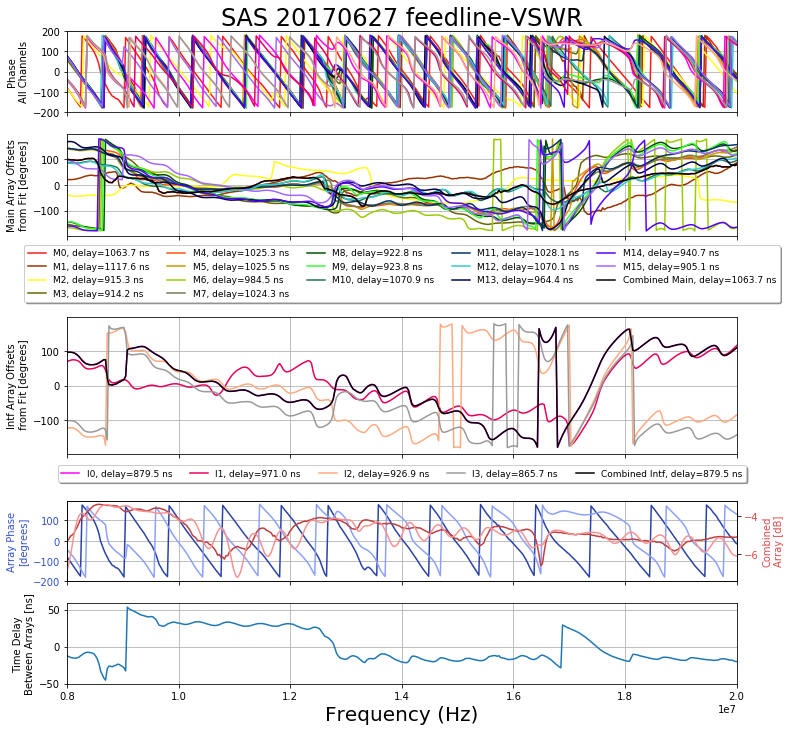

In [16]:
%run def_plot_functions.py
plot_data(working_dataframe, channels, plot_title, colour_dictionary,
                       linear_fit_dict, missing_data, data_description)

<img src="./pictures/Clyde-River-2018 total-path.png" width="800" align="center">

# Why might we have a non-linear phase path across frequency?

* non-linear components, such as amplifiers, switches, filters, etc. in the receive paths. 

# This directly affects elevation measurements. 

# Conclusion:
## Generally,
- We can gain a better understanding of our data by understanding our hardware.
- If anyone is interested in looking at or using hardware data, **talk to me!**
- If anyone has suggestions for hardware measurements that would help with data analysis, **talk to me!**

## Specifically,
- It is very difficult to calibrate tdiff as a single value because the phase delay from antenna to receiver is not always linear.
- This is due to active components such as amplifiers and switches in the path. 
- Maybe a different method of calibrating would be more appropriate.

# Sources
http://www.rfwireless-world.com/Terminology/SNA-Scalar-Network-Analyzer-vs-VNA-Vector-Network-Analyzer.html

In [ ]:
# If anyone wants to take a look at what the code is doing. 
#%pycat load_data.py
#%pycat ../tdiff_path/retrieve_data/retrieve_data.py
#%pycat ../tdiff_path/dataset_operations/dataset_operations.py

In [ ]:
%cat hdw.dat.sas

<img src="./pictures/Rankin-Inlet-2018 total-path.png" width="1000" align="center">